# Rotatividade de clientes

Este projeto tem como objetivo desenvolver um modelo preditivo de machine learning para analisar e prever a rotatividade (churn) de clientes em uma empresa de telecomunicações.
A metodologia envolve uma análise abrangente dos dados históricos dos clientes, identificando padrões comportamentais e características distintivas entre aqueles que mantêm seus serviços ativos e os que optam pelo cancelamento. Com base nessa análise, será desenvolvido um modelo capaz de identificar precocemente clientes com maior probabilidade de cancelamento, permitindo ações preventivas de retenção."

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import os

## Importando os Dados

In [2]:
# Lendo os arquivos Parquet
df_contracts = pd.read_parquet('dados/contract.parquet')
df_internet = pd.read_parquet('dados/internet.parquet')
df_personal = pd.read_parquet('dados/personal.parquet')
df_phone = pd.read_parquet('dados/phone.parquet')

Observado que as colunas de cada dataset esta com letras minisculas e maiusculas sera transformada em letras minusculas para facilirar a manipulação

### Transformando o cabeçalho de cada dataset em minusculos

In [3]:
df_contracts.columns = df_contracts.columns.str.lower()

In [4]:
df_internet.columns = df_internet.columns.str.lower()

In [5]:
df_personal.columns = df_personal.columns.str.lower()

In [6]:
df_phone.columns = df_phone.columns.str.lower()

### Contract com as informações de contratos

Dicionario dos Dados

| **Nome**             | **Descrição**                                                                 |
|-----------------------|------------------------------------------------------------------------------|
| **customerid**        | Identificador único do cliente.                                              |
| **begindate**         | Data de início do contrato ou serviço.                                       |
| **enddate**           | Data de término do contrato ou serviço (ou vazio se o contrato ainda estiver ativo). |
| **type**              | Tipo de contrato (mensal, anual, etc.).                                      |
| **paperlessbilling**  | Indica se o cliente optou por fatura digital (sim ou não).                   |
| **paymentmethod**     | Método de pagamento utilizado pelo cliente (cartão de crédito, débito automático, etc.). |
| **monthlycharges**    | Valor mensal cobrado pelo serviço ou contrato.                               |
| **totalcharges**      | Valor total acumulado cobrado ao cliente.                                    |



In [7]:
df_contracts

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,begindate_float
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1806
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2811
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1898
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,3146
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1928
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,2505
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,3966
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2112
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,1990


### Descrição dos dados

In [8]:
df_contracts.describe().T

,count,mean,min,25%,50%,75%,max,std
begindate,7043,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
monthlycharges,7043.0,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
totalcharges,7032.0,2283.300441,18.8,401.45,1397.475,3794.7375,8684.8,2266.771362
begindate_float,7043.0,2781.45705,1775.0,2081.0,2658.0,3481.0,4089.0,736.596428


### Informação dos dados DF Contracts

In [9]:
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   begindate_float   7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


Observado que não temos dados nulos tambem observamos o tipo de dado que esta no dataset DF contracts, primeiro ponto de atenção sera necessrio mudar o formato de begindate de object para date time, transformar totalcharges de object para float

### Transformando a coluna BeginDate em data

In [10]:

df_contracts['begindate'] = pd.to_datetime(df_contracts['begindate'], format = '%Y-%m-%d').dt.date
df_contracts['totalcharges'] = pd.to_numeric(df_contracts['totalcharges'],errors='coerce')

### Verificação de dados duplicados DF Contracts

In [11]:
df_contracts.duplicated().sum()

0

### Verificação de dados nulos DF Contracts

In [12]:
df_contracts.isna().sum()

customerid           0
begindate            0
enddate              0
type                 0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
begindate_float      0
dtype: int64

### Verificação da coluna BeginDate

In [13]:
df_contracts['begindate'].astype

<bound method NDFrame.astype of 0       2020-01-01
1       2017-04-01
2       2019-10-01
3       2016-05-01
4       2019-09-01
           ...    
7038    2018-02-01
7039    2014-02-01
7040    2019-03-01
7041    2019-07-01
7042    2014-08-01
Name: begindate, Length: 7043, dtype: object>

###  Transformando a coluna begindates em float

In [14]:

df_contracts['begindate'] = pd.to_datetime(df_contracts['begindate'], errors='coerce')
df_contracts['begindate_float'] = (pd.to_datetime('today') - df_contracts['begindate']).dt.days
print(df_contracts[['begindate', 'begindate_float']])



      begindate  begindate_float
0    2020-01-01             1806
1    2017-04-01             2811
2    2019-10-01             1898
3    2016-05-01             3146
4    2019-09-01             1928
...         ...              ...
7038 2018-02-01             2505
7039 2014-02-01             3966
7040 2019-03-01             2112
7041 2019-07-01             1990
7042 2014-08-01             3785

[7043 rows x 2 columns]



No Python, a manipulação de números em um DataFrame facilita a interação com modelos, pois os algoritmos de machine learning geralmente trabalham melhor com valores numéricos em vez de categorias como "sim" e "não"

### Descrição dos Dados

In [15]:
df_contracts.describe().T

,count,mean,min,25%,50%,75%,max,std
begindate,7043,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
monthlycharges,7043.0,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
totalcharges,7032.0,2283.300441,18.8,401.45,1397.475,3794.7375,8684.8,2266.771362
begindate_float,7043.0,2781.45705,1775.0,2081.0,2658.0,3481.0,4089.0,736.596428


### Internet com as informações sobre os planos de internet oferecidos

Dicionario dos Dados

| **Nome**             | **Descrição**                                                                 |
|-----------------------|------------------------------------------------------------------------------|
| **customerid**        | Identificador único do cliente.                                              |
| **internetservice**   | Tipo de serviço de internet assinado pelo cliente (DSL, fibra óptica, nenhum). |
| **onlinesecurity**    | Indica se o cliente possui serviço de segurança online (sim ou não).         |
| **onlinebackup**      | Indica se o cliente possui serviço de backup online (sim ou não).            |
| **deviceprotection**  | Indica se o cliente possui serviço de proteção para dispositivos (sim ou não). |
| **techsupport**       | Indica se o cliente possui suporte técnico adicional (sim ou não).           |
| **streamingtv**       | Indica se o cliente possui serviço de streaming de TV (sim ou não).          |
| **streamingmovies**   | Indica se o cliente possui serviço de streaming de filmes (sim ou não).      |


In [16]:
df_internet

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


### Descrição dos planos de internet

In [17]:
df_internet.describe().T

,count,unique,top,freq
customerid,5517,5517,7590-VHVEG,1
internetservice,5517,2,Fiber optic,3096
onlinesecurity,5517,2,No,3498
onlinebackup,5517,2,No,3088
deviceprotection,5517,2,No,3095
techsupport,5517,2,No,3473
streamingtv,5517,2,No,2810
streamingmovies,5517,2,No,2785


Não foram identificados dados ausentes ou duplicados neste conjunto de dados.

A quantidade de clientes neste conjunto é inferior àquela do conjunto que contém informações de contratos. Isso pode indicar que clientes sem qualquer tipo de serviço ou opção de internet não estão representados neste DataFrame.

### Informação dos planos de internet

In [18]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


O dataset apresenta informações sobre 5517 clientes de uma empresa de telecomunicações, contendo dados sobre seus serviços contratados. Os registros incluem 8 colunas diferentes, abrangendo serviços como internet, segurança online, backup, proteção de dispositivos e streaming. O conjunto de dados está completo, sem valores nulos, e seu formato esta como object.

### Observando os planos de internet se ha dados duplicados

In [19]:
print(df_internet.duplicated().sum())

0


### Observando os planos de internet se ha dados nulos

In [20]:
df_internet.isna().sum()

customerid          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64

Apos esta analise observamos que não ha linhas duplicadas e nem numeros nulos

In [21]:
total_contrats = df_contracts['customerid'].count()
total_internet =  df_internet['customerid'].count()

print('total contratos registrados: ',total_contrats)
print('total contratos de internet: ',total_internet)


total contratos registrados:  7043
total contratos de internet:  5517


É possível observar que há um número maior de contratos cadastrados no sistema sem nenhum tipo de serviço ou opção de internet do que contratos ativos vinculados a clientes.

### DF Personal com as informações pessoais de cada cliente

Dicionario dos Dados: 

| **Nome**             | **Descrição**                                                                |
|-----------------------|-----------------------------------------------------------------------------|
| **customerid**        | Identificador único do cliente.                                             |
| **gender**            | Gênero do cliente (masculino, feminino, etc.).                              |
| **seniorcitizen**     | Indica se o cliente é idoso (1 para idoso, 0 para não idoso).               |
| **partner**           | Indica se o cliente possui parceiro ou cônjuge (sim ou não).               |
| **dependents**        | Indica se o cliente possui dependentes (sim ou não).                        |


In [22]:
df_personal

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


### DF Personal estatisticas dos dados

In [23]:
df_personal.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


### DF Personal informações dos dados

In [24]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### DF Personal observando se ha linhas duplicadas

In [25]:
df_personal.duplicated().sum()

0

### DF Personal observando se ha dados nulos

In [26]:
df_personal.isna().sum()

customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

## DF Phone com as informações de multiplas linhas

Dicionario dos dados:

| **Nome**            | **Descrição**                                                      |
|----------------------|-------------------------------------------------------------------|
| **customerid**       | Identificador único do cliente.                                   |
| **multiplelines**    | Indica se o cliente possui múltiplas linhas telefônicas (sim, não ou nenhum). |


### DF Phone com as informações de multiplas linhas

In [27]:
df_phone

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


### DF Phone cdescrição

In [28]:
df_phone.describe().T

,count,unique,top,freq
customerid,6361,6361,5575-GNVDE,1
multiplelines,6361,2,No,3390


### DF Phone informações

In [29]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


O DataFrame apresenta um número menor de linhas em comparação com o conjunto de dados de contratos. Isso indica que nem todos os clientes utilizam linhas telefônicas e outros serviços simultaneamente. Além disso, algumas colunas estão no formato object, o que pode exigir ajustes para análises mais detalhadas.

#### DF Phone observando se ha linhas duplicadas

In [30]:
df_phone.duplicated().sum()

0

#### DF Phone observando se ha valor nulo

In [31]:
df_phone.isna().sum()

customerid       0
multiplelines    0
dtype: int64

Observação que os dados multiplelines deve ser tipo inteiro porque não existe valor fracionado.

Para dar sequência à análise e obter uma visualização mais completa de todos os dados disponíveis, combinei as tabelas em uma única. Para isso, utilizei o ID único de cada cliente, que é o mesmo em todos os conjuntos de dados, como chave de agrupamento.

### Agrupando o conjunto de dados

In [32]:
df = pd.merge(df_contracts,df_internet, on = 'customerid', how = 'left')
df = pd.merge(df ,df_personal, on = 'customerid', how = 'left')
df = pd.merge(df ,df_phone, on = 'customerid', how = 'left')
df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,begindate_float,internetservice,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1806,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2811,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1898,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,3146,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1928,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,2505,DSL,...,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,3966,Fiber optic,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2112,DSL,...,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,1990,Fiber optic,...,No,No,No,No,No,Male,1,Yes,No,Yes


Adicionei uma nova coluna ao DataFrame que indica o status do contrato: 

- 0 Contratos encerrados 
- 1 Contratos ativos

In [33]:
df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce').dt.date
df['encerrado'] = df['enddate'].apply(lambda x: 0 if pd.isnull(x) else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   begindate_float   7043 non-null   int64         
 9   internetservice   5517 non-null   object        
 10  onlinesecurity    5517 non-null   object        
 11  onlinebackup      5517 non-null   object        
 12  deviceprotection  5517 non-null   object        
 13  techsupport       5517 non-null   object        
 14  streamingtv       5517 n

/tmp/ipykernel_12761/2411639463.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce').dt.date


### descrição do novo dataset

In [34]:
df.describe()

,begindate,monthlycharges,totalcharges,begindate_float,seniorcitizen,encerrado
count,7043,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692,2283.300441,2781.457050,0.162147,0.265370
min,2013-10-01 00:00:00,18.250000,18.800000,1775.000000,0.000000,0.000000
25%,2015-06-01 00:00:00,35.500000,401.450000,2081.000000,0.000000,0.000000
50%,2017-09-01 00:00:00,70.350000,1397.475000,2658.000000,0.000000,0.000000
75%,2019-04-01 00:00:00,89.850000,3794.737500,3481.000000,0.000000,1.000000
max,2020-02-01 00:00:00,118.750000,8684.800000,4089.000000,1.000000,1.000000
std,NaN,30.090047,2266.771362,736.596428,0.368612,0.441561


In [35]:
encerrada = df['enddate'].count()
encerrada

1869

In [36]:
encerrament = df['encerrado'].count()
encerrament

7043

In [37]:
finalizados = ((encerrada  / encerrament)*100)
print(f'quantidade de contratos suspenso: {finalizados:.2f}%')

quantidade de contratos suspenso: 26.54%


Após consolidar os dados de todas as tabelas em uma única estrutura, mantivemos os mesmos parâmetros presentes nas tabelas originais. A principal diferença é a adição da coluna "encerrado", que indica que 26,54% dos contratos foram finalizados.

### Adicionando a coluna que calcula o tempo de contrato até o encerramento


In [38]:
from datetime import datetime
data_atual = datetime.now()
data_atual

datetime.datetime(2024, 12, 11, 23, 23, 1, 675975)

In [39]:
df['tempo_contrato'] = ((df['enddate'] - df['begindate']).dt.days / 30 
                        if 'encerrado' == 1 
                        else (data_atual - df['begindate']).dt.days / 30)

df['tempo_contrato']

0        60.200000
1        93.700000
2        63.266667
3       104.866667
4        64.266667
           ...    
7038     83.500000
7039    132.200000
7040     70.400000
7041     66.333333
7042    126.166667
Name: tempo_contrato, Length: 7043, dtype: float64

In [40]:
df['internetservice'].fillna('No', inplace = True)
df['onlinesecurity'].fillna('No', inplace = True)
df['onlinebackup'].fillna('No', inplace = True)
df['deviceprotection'].fillna('No', inplace = True)
df['techsupport'].fillna('No', inplace = True)
df['streamingtv'].fillna('No', inplace = True)
df['streamingmovies'].fillna('No', inplace = True)
df['multiplelines'].fillna('No', inplace = True)

###  Filtrar linhas e colunas com valores nulos ou ausente

In [41]:
df[df['totalcharges'].isnull()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,begindate_float,internetservice,...,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,encerrado,tempo_contrato
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,1775,DSL,...,Yes,Yes,No,Female,0,Yes,Yes,No,0,59.166667
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,1775,No,...,No,No,No,Male,0,No,Yes,No,0,59.166667
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,1775,DSL,...,No,Yes,Yes,Female,0,Yes,Yes,No,0,59.166667
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,1775,No,...,No,No,No,Male,0,Yes,Yes,Yes,0,59.166667
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,1775,DSL,...,Yes,Yes,No,Female,0,Yes,Yes,No,0,59.166667
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,1775,No,...,No,No,No,Male,0,Yes,Yes,No,0,59.166667
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,1775,No,...,No,No,No,Male,0,Yes,Yes,Yes,0,59.166667
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,1775,No,...,No,No,No,Female,0,Yes,Yes,No,0,59.166667
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,1775,No,...,No,No,No,Male,0,Yes,Yes,No,0,59.166667
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,1775,DSL,...,Yes,Yes,No,Female,0,Yes,Yes,Yes,0,59.166667


In [42]:
df['totalcharges'].isna().sum()/len(df)

0.001561834445548772

In [43]:
df = df.dropna(subset=['totalcharges'])

In [44]:
df[df['totalcharges'].isna()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,begindate_float,internetservice,...,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,encerrado,tempo_contrato


Todos os dados ausentes na coluna TotalCharges eram de contratos ativos, e representavam menos de 1% de todo o DF, por isso achei mais viável retirar essas linhas e continuar com as análises.

### Categorizando as colunas de charges e tempo de contrato

A função qcut do Pandas pd.qcut(): é usada para dividir os dados em intervalos (quantis). Ela tenta dividir a série em q quantis, ou seja, q grupos de dados, onde cada grupo contém aproximadamente o mesmo número de elementos.

In [45]:
pd.qcut(df['monthlycharges'], q=4).unique()

[(18.249, 35.588], (35.588, 70.35], (70.35, 89.862], (89.862, 118.75]]
Categories (4, interval[float64, right]): [(18.249, 35.588] < (35.588, 70.35] < (70.35, 89.862] < (89.862, 118.75]]

In [46]:
df['quantis_mensais'] = pd.qcut(df['monthlycharges'], q=4)

/tmp/ipykernel_12761/2408923091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quantis_mensais'] = pd.qcut(df['monthlycharges'], q=4)


In [47]:
pd.qcut(df['totalcharges'], q=4).unique()

[(18.799, 401.45], (1397.475, 3794.738], (401.45, 1397.475], (3794.738, 8684.8]]
Categories (4, interval[float64, right]): [(18.799, 401.45] < (401.45, 1397.475] < (1397.475, 3794.738] < (3794.738, 8684.8]]

In [48]:
df['quantis_total'] = pd.qcut(df['totalcharges'], q=4)

/tmp/ipykernel_12761/173357899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quantis_total'] = pd.qcut(df['totalcharges'], q=4)


In [49]:
pd.qcut(df['tempo_contrato'], q=4).unique()

[(60.199000000000005, 69.367], (88.6, 116.033], (69.367, 88.6], (116.033, 136.3]]
Categories (4, interval[float64, right]): [(60.199000000000005, 69.367] < (69.367, 88.6] < (88.6, 116.033] < (116.033, 136.3]]

In [50]:
df['quantis_tempo'] = pd.qcut(df['tempo_contrato'], q=5)

/tmp/ipykernel_12761/1908214466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quantis_tempo'] = pd.qcut(df['tempo_contrato'], q=5)


Para a coluna monthlycharges, dividi os dados em faixas com o mesmo número de elementos em cada grupo, a fim de analisar o comportamento dos integrantes de cada faixa em relação às demais métricas. Isso resultou na criação da coluna quantis_mensais

In [51]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'].fillna(0, inplace=True)
df.dropna(subset=['totalcharges'], inplace=True)
pd.qcut(df['totalcharges'], q=4).unique()

/tmp/ipykernel_12761/2887945697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
/tmp/ipykernel_12761/2887945697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['totalcharges'].fillna(0, inplace=True)
/tmp/ipykernel_12761/2887945697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subse

[(18.799, 401.45], (1397.475, 3794.738], (401.45, 1397.475], (3794.738, 8684.8]]
Categories (4, interval[float64, right]): [(18.799, 401.45] < (401.45, 1397.475] < (1397.475, 3794.738] < (3794.738, 8684.8]]

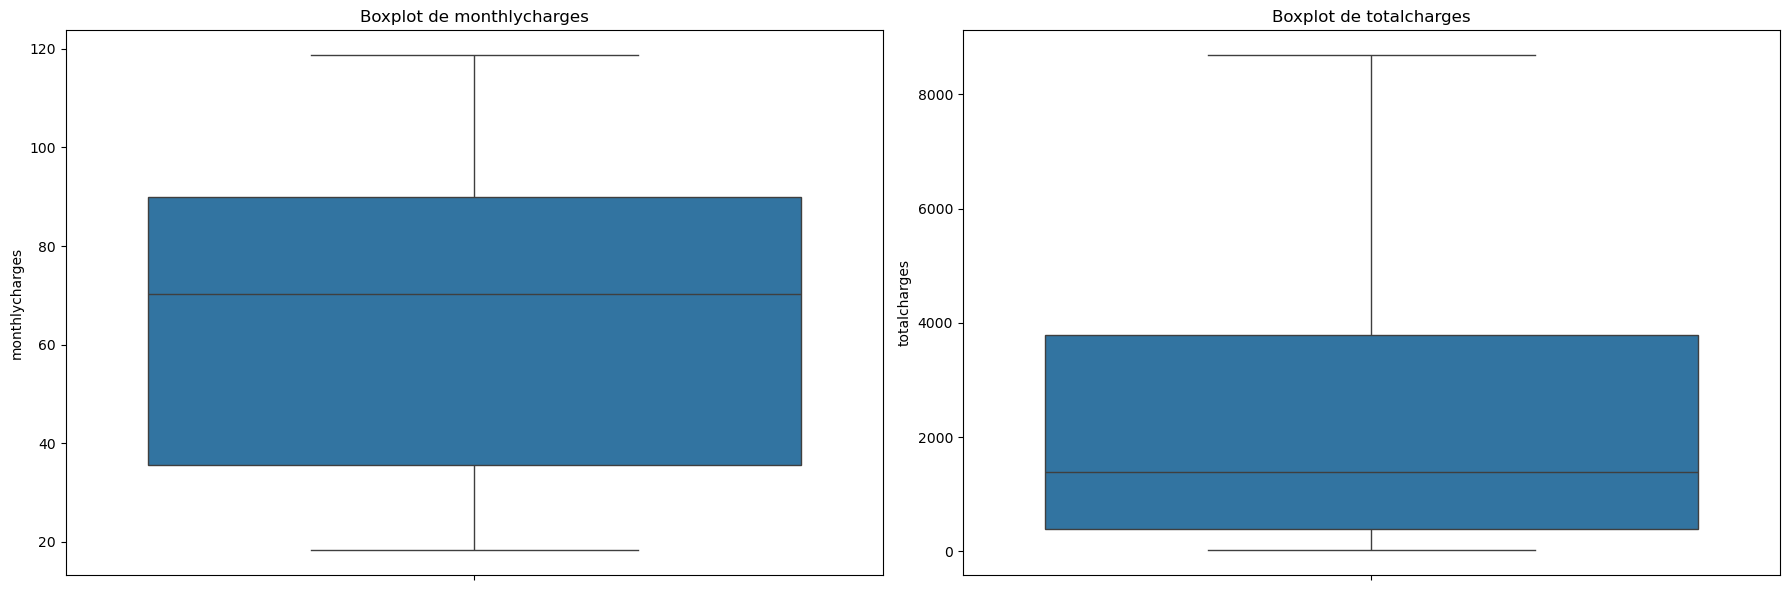

In [52]:
numeric_cols = ['monthlycharges', 'totalcharges']
plt.figure(figsize=(18, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

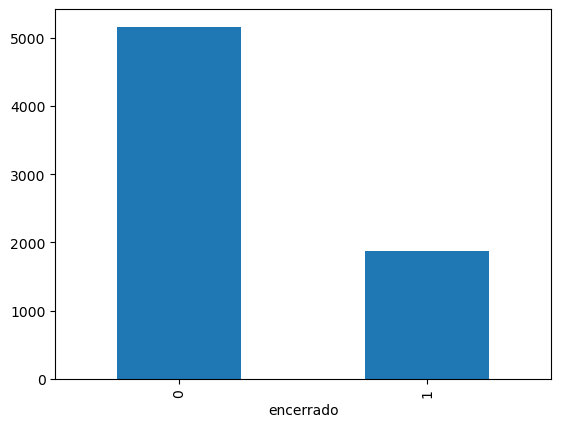

In [53]:
df['encerrado'].value_counts().plot(kind='bar');

O gráfico apresenta dois boxplots que revelam a distribuição das cobranças mensais e totais dos clientes da empresa. Os boxplots indicam que as cobranças mensais têm uma mediana em torno de 70 unidades monetárias, enquanto as cobranças totais centram-se em aproximadamente 1500 unidades. Observa-se a presença de valores atípicos em ambas as distribuições, sendo mais pronunciados nas cobranças totais, onde alguns clientes alcançam valores superiores a 8000 unidades monetárias.

O grafico mostrar a quantidade de clientestes cadastrados ativo(0) e clientest inativo(1)

In [54]:
df[df['encerrado'] == 1]['type'].value_counts()

type
Month-to-month    1655
One year           166
Two year            48
Name: count, dtype: int64

### Realizando análise descritiva das colunas numéricas monthlycharges

In [55]:
num_cols = ['monthlycharges', 'totalcharges']
df.groupby(['encerrado'])[num_cols].describe(percentiles=[])

monthlycharges                                              \
                   count       mean        std    min    50%     max   
encerrado                                                              
0                 5163.0  61.307408  31.094557  18.25  64.45  118.75   
1                 1869.0  74.441332  24.666053  18.85  79.65  118.35   

          totalcharges                                                     
                 count         mean          std    min      50%      max  
encerrado                                                                  
0               5163.0  2555.344141  2329.456984  18.80  1683.60  8672.45  
1               1869.0  1531.796094  1890.822994  18.85   703.55  8684.80

Na coluna monthlycharges e possivel ver clientes tendem a contratar pacotes mais básicos de internet, abstendo-se de serviços complementares como segurança online, backup online, proteção de dispositivos e suporte técnico

### Tabela de contingência (tabela cruzada)

In [56]:
pd.crosstab(df['encerrado'], df['internetservice'], normalize=True)

internetservice,DSL,Fiber optic,No
encerrado,,,
0,0.278299,0.255830,0.200085
1,0.065273,0.184443,0.016069


Conforme dados acima e possivel observar que a maioria dos rientests que cancela o serviço de internet esta estva com serviço ativo de fibra otica pode.

###  Média de contratos encerrados para cada tipo de serviço de internet.

In [57]:
encerrado_internet_service = df.groupby('internetservice')['encerrado'].mean().reset_index()
encerrado_internet_service

,internetservice,encerrado
0,DSL,0.189983
1,Fiber optic,0.418928
2,No,0.074342


### Tabela de contingência (tabela cruzada)  para multiplelines

In [58]:
pd.crosstab(df['encerrado'], df['multiplelines'], normalize=True)

multiplelines,No,Yes
encerrado,,
0,0.433163,0.301052
1,0.144909,0.120876


### Encerramentos por genero

In [59]:
encerrado_gender = df.groupby('gender')['encerrado'].mean().reset_index()
encerrado_gender

,gender,encerrado
0,Female,0.269595
1,Male,0.262046


### Análises das de relação ao encerrameto do contrato

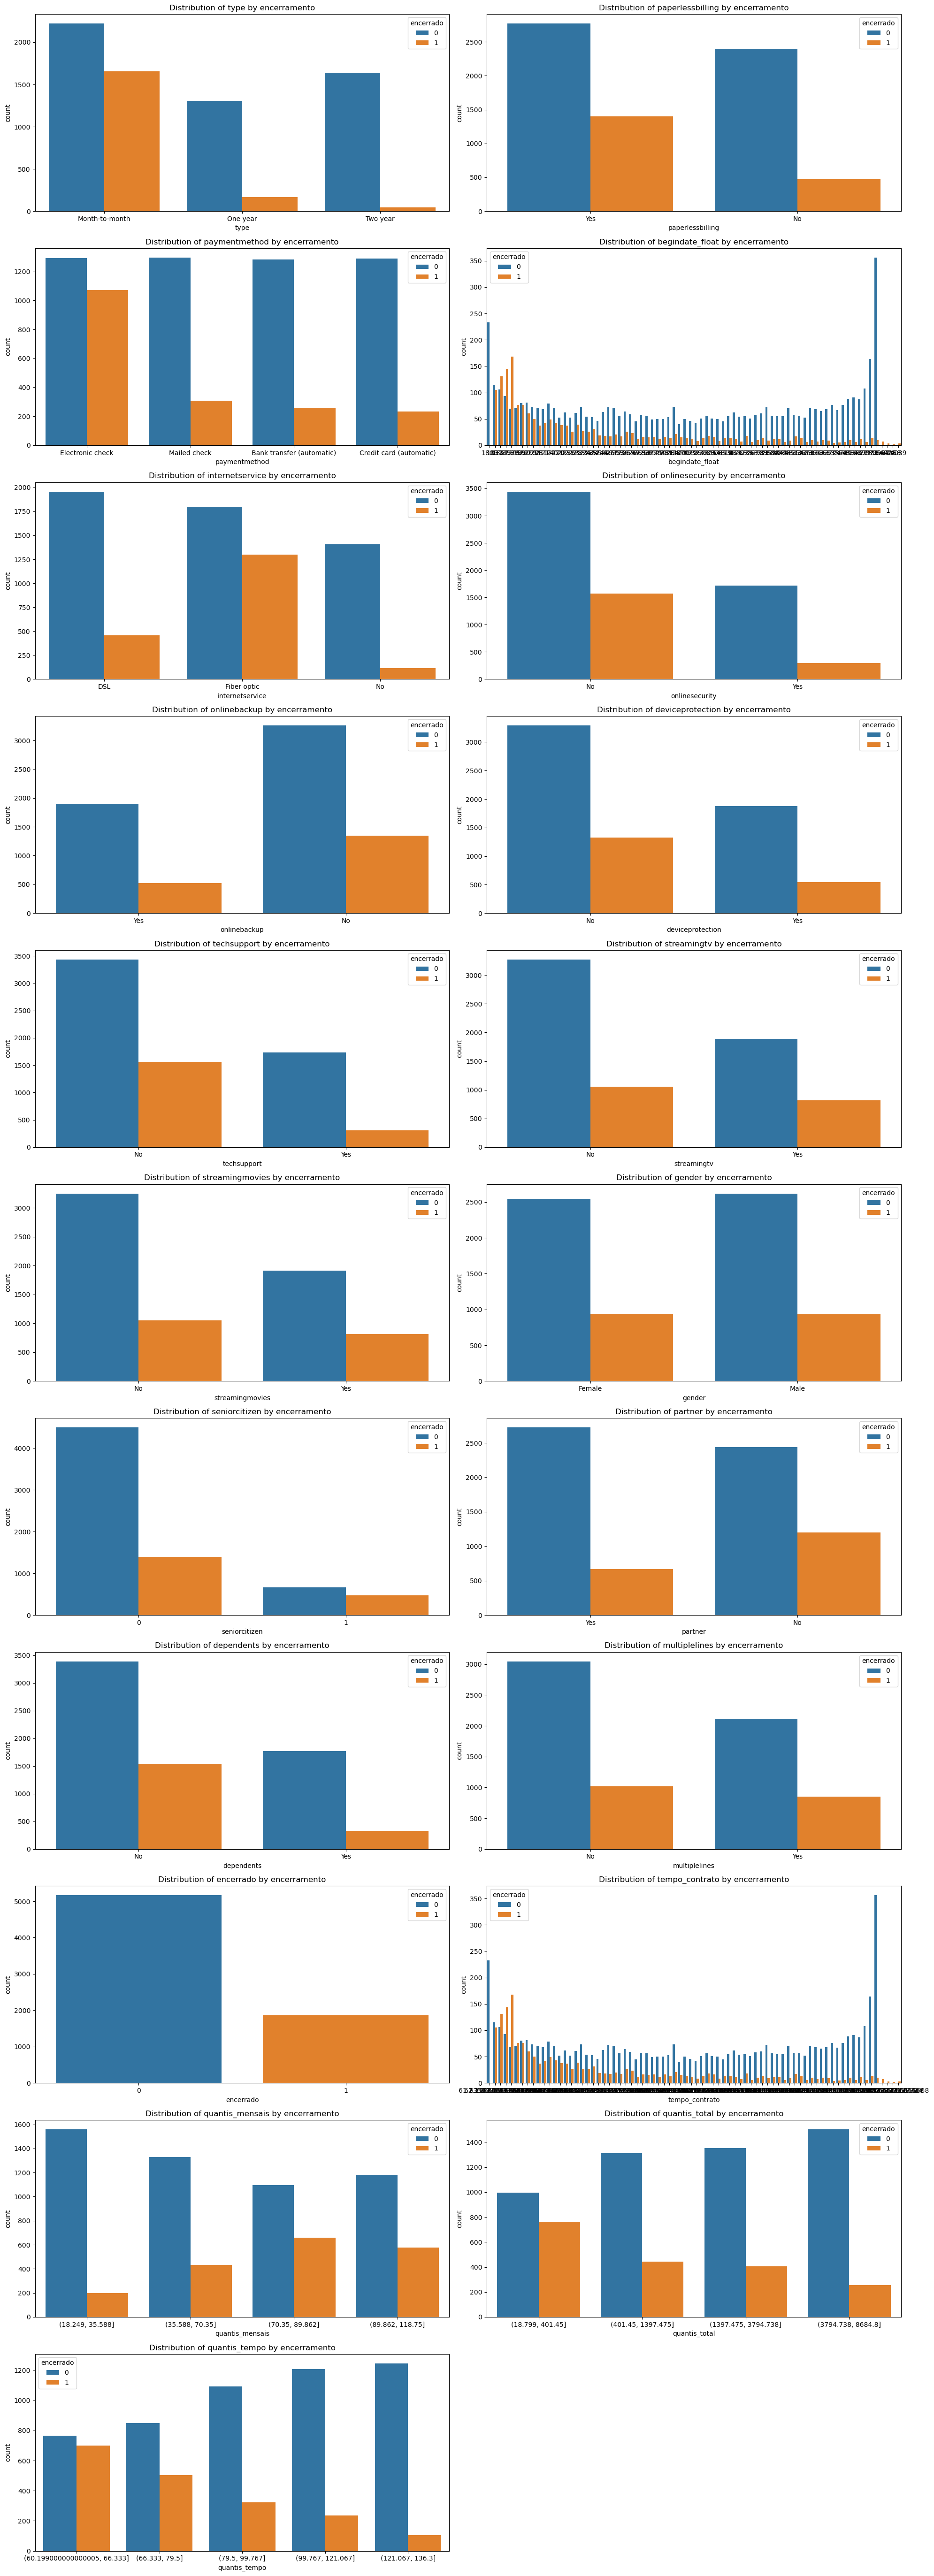

In [60]:
columns = [col for col in df.columns if col not in ['customerid', 'begindate', 'enddate', 'monthlycharges', 'totalcharges', 'encerramedo', 'monthlycharges_bucket', 'totalchargesbucket']]
n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
plt.figure(figsize=(20, n_rows * 5)) 
for i, column in enumerate(columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=column, hue='encerrado', data=df)
    plt.title(f'Distribution of {column} by encerramento')
    plt.tight_layout()

Analisando os grafico revela padrões significativos que podem explicar a taxa de encerramento de contrato(churn) de 26,54% observada na base de clientes. O perfil predominante dos usuários que cancelam os serviços apresenta três características principais: optam por planos mensais (month-to-month), preferem pagamentos não automatizados via cheque eletrônico e são majoritariamente clientes sem parceiros ou dependentes. Adicionalmente, estes clientes tendem a contratar pacotes mais básicos de internet, abstendo-se de serviços complementares como securityonline, backuponline, proteção de dispositivos e suporte técnico, sugerindo uma menor vinculação com a empresa.

### Matrix Correlação com contratos encerrados

Correlação das variáveis com 'encerrado':
encerrado          1.000000
monthlycharges     0.192858
seniorcitizen      0.150541
totalcharges      -0.199484
tempo_contrato    -0.313547
begindate_float   -0.313547
Name: encerrado, dtype: float64


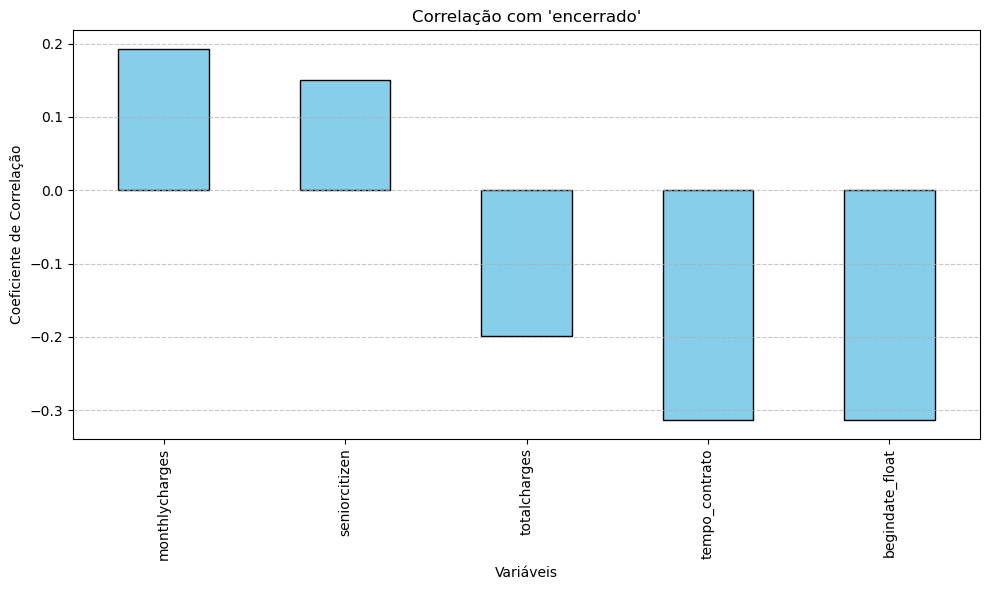

In [61]:
numerical_df = df.select_dtypes(include=['number'])
if 'encerrado' in numerical_df.columns:
    correlacao_encerrado = numerical_df.corr()['encerrado'].sort_values(ascending=False)
    print("Correlação das variáveis com 'encerrado':")
    print(correlacao_encerrado)

    
    correlacao_encerrado.drop('encerrado', inplace=True)
    correlacao_encerrado.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
    plt.title("Correlação com 'encerrado'")
    plt.ylabel("Coeficiente de Correlação")
    plt.xlabel("Variáveis")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'encerrado' não é uma coluna numérica ou não está presente no DataFrame.")

- Monthlycharges (valor mensal): A correlação positiva observada indica que, à medida que o valor mensal aumenta, há uma maior probabilidade de o contrato ser encerrado. Isso sugere que clientes com planos mais caros tendem a cancelar seus serviços com maior frequência.

- Seniorcitizen (idoso): Embora mais fraca, a correlação positiva sugere que clientes idosos podem apresentar uma ligeira tendência a cancelar seus contratos.

## Conclusão

Iniciamos a tarefa separadamente e os dados foram cuidadosamente verificados. Após o carregamento, os dados foram unidos em um único dataframe, denominado df_geral. A partir desse momento, iniciou-se o processo de ajuste dos dados para possibilitar as análises subsequentes.

As colunas de data (BeginDate e EndDate) foram convertidas para o tipo datetime.
Foi criada a coluna encerrado para classificar os contratos como ativos (0) ou encerrados (1). Observou-se que cerca de 26,5% dos contratos foram encerrados.
Em relação aos dados ausentes:

Identificou-se que havia valores ausentes nas colunas relacionadas aos serviços de internet. Estes estavam ausentes devido à ausência de serviço de internet, sendo assim, os valores ausentes foram preenchidos com "no", de acordo com a lógica da coluna.
O mesmo procedimento foi aplicado à coluna MultipleLines.

A coluna TotalCharges também apresentava dados ausentes, mas como representavam apenas 0,1% do total dos dados, as linhas correspondentes foram removidas.
Foi adicionada uma nova coluna, tempo_contratos, contendo o tempo de contrato de todos os contratos encerrados.

Utilizou-se a função pd.qcut() para criar categorias e segmentar as colunas MonthlyCharges, TotalCharges e tempo_contrato, com o objetivo de facilitar visualizações e análises do comportamento desses dados.


## Próximos Passos


### Preparação dos Modelos

Para os modelos de **Árvore de Decisão**, **Floresta Aleatória** e **Regressão Logística**, o primeiro passo será preparar os dados, removendo colunas desnecessárias e definindo as variáveis preditoras (features) e o objetivo da predição.

#### Objetivo da Predição
O objetivo será prever a coluna **'encerrado'**, que indica se o cliente deixou (1) ou permaneceu (0) na companhia telefônica. Este será o alvo da predição.

#### Features
As colunas a serem removidas incluem:
- **customerID**: Identificação do cliente, que não é relevante para a modelagem.
- **EndDate**: Como a coluna **'encerrado'** já contém as informações necessárias, esta coluna será descartada.
- Colunas auxiliares criadas para classificar as recargas e o tempo por faixas, que já são abordadas pelas variáveis originais.

#### Divisão dos Dados
Os dados serão divididos em 80% para treinamento e 20% para testes, garantindo uma boa distribuição entre os conjuntos.

#### Preparação dos Dados
Para garantir a qualidade da modelagem, algumas etapas de pré-processamento serão seguidas:
1. **Transformação das Variáveis Categóricas**:
   - Para **Árvore de Decisão** e **Floresta Aleatória**, será utilizada a **Classificação One-Hot** para transformar as variáveis categóricas em variáveis numéricas. 
   - Para **Catboost**, a **Codificação de Rótulos**  será aplicada nas variáveis categóricas

2. **Escalabilidade dos Dados**:
   - Será realizada a **padronização** dos dados, assegurando que todas as features estejam na mesma escala e não influenciem o desempenho do modelo devido a diferenças em suas unidades.

#### Ajuste de Hiperparâmetros
Antes de treinar os modelos, será utilizado o **GridSearchCV** para encontrar os melhores hiperparâmetros para cada modelo, com o intuito de maximizar a eficácia de cada um.

Ao final, os modelos estarão prontos para realizar a predição de forma otimizada, seguindo as melhores práticas de preparação de dados e ajuste de parâmetros.


Machine learning

- Nesta seção irei separar as features e target, irei treinar 3 modelos, selecionar o melhor com  base em auc-roc e após isso aplicar  hiperparâmetros.
    



In [62]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

target = df['encerrado']
features = df.drop('encerrado', axis=1)

### Balanceamento de dados

In [63]:
features = features.drop(columns = ['customerid', 'enddate', 'quantis_tempo', 'quantis_mensais', 'quantis_total'])
features.info()
features = features.astype(str)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7032 non-null   datetime64[ns]
 1   type              7032 non-null   object        
 2   paperlessbilling  7032 non-null   object        
 3   paymentmethod     7032 non-null   object        
 4   monthlycharges    7032 non-null   float64       
 5   totalcharges      7032 non-null   float64       
 6   begindate_float   7032 non-null   int64         
 7   internetservice   7032 non-null   object        
 8   onlinesecurity    7032 non-null   object        
 9   onlinebackup      7032 non-null   object        
 10  deviceprotection  7032 non-null   object        
 11  techsupport       7032 non-null   object        
 12  streamingtv       7032 non-null   object        
 13  streamingmovies   7032 non-null   object        
 14  gender            7032 non-nu

In [64]:
encoder = OrdinalEncoder()
features_inicial = pd.DataFrame(encoder.fit_transform(features), columns=features.columns)
features_inicial

,begindate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,begindate_float,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,tempo_contrato
0,75.0,0.0,1.0,2.0,446.0,2504.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.0
1,42.0,1.0,0.0,3.0,801.0,1465.0,33.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,69.0
2,72.0,0.0,1.0,3.0,739.0,156.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,39.0
3,31.0,1.0,0.0,0.0,570.0,1399.0,44.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
4,71.0,0.0,1.0,2.0,1032.0,924.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,52.0,1.0,1.0,3.0,1294.0,1596.0,23.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,59.0
7028,4.0,1.0,1.0,1.0,59.0,5697.0,71.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,31.0
7029,65.0,0.0,1.0,2.0,441.0,2993.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,46.0
7030,69.0,0.0,1.0,3.0,1098.0,2659.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,42.0



### Dividindo o conjunto de dados


In [65]:
from sklearn.preprocessing import StandardScaler

numeric = ['monthlycharges', 'totalcharges', 'tempo_contrato', 'begindate']
scaler = StandardScaler()
scaler.fit(features_inicial[numeric])
features_inicial[numeric] = scaler.transform(features_inicial[numeric])

In [66]:
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_inicial, target, test_size=0.20, random_state=12345)

### Árvore de decisão


In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

model_dtc = DecisionTreeClassifier(random_state=12345)

grid_search = GridSearchCV(estimator = model_dtc,
                              param_grid = {'max_depth':range(1,50),
                                            'min_samples_split': [2, 5, 10],
                                            'min_samples_leaf': [1, 2, 5]},
                              scoring='roc_auc', cv = 3)


grid_search.fit(features_train,target_train)


grid_search.best_params_

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [68]:
from sklearn.metrics import accuracy_score, roc_auc_score

model_dtc = DecisionTreeClassifier(random_state=12345, max_depth = 8, min_samples_leaf = 1, min_samples_split=10)
model_dtc.fit(features_train,target_train)

target_pred = model_dtc.predict(features_test)

accuracy = accuracy_score(target_test, target_pred)
target_one_pred = model_dtc.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, target_one_pred)

print('Acurácia = ', accuracy)
print('AUC-ROC = ', roc_auc)

Acurácia =  0.8009950248756219
AUC-ROC =  0.8483548874020886


Após treinar o modelo e realizar as predições, analisamos as métricas de avaliação. O modelo apresentou uma acurácia de 0,81 e uma AUC-ROC de 0,87, indicando um bom desempenho. Esses resultados sugerem que o modelo está bem ajustado e atende de forma eficaz aos requisitos do projeto. Agora, vamos prosseguir com a análise dos demais modelos

### Floresta Aleatória

In [69]:
from sklearn.ensemble import RandomForestClassifier

model_rfc = RandomForestClassifier(random_state=12345)
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10]}

grid_search = GridSearchCV(model_rfc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train, target_train)
grid_search.best_params_


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [70]:

model_rfc = RandomForestClassifier(random_state= 12345, max_depth = None, min_samples_split = 2, n_estimators = 200)
model_rfc.fit(features_train,target_train)

target_pred = model_rfc.predict(features_test)

accuracy = accuracy_score(target_test, target_pred)
target_one_pred = model_rfc.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, target_one_pred)

print('Acurácia = ', accuracy)
print('AUC-ROC = ', roc_auc)

Acurácia =  0.8571428571428571
AUC-ROC =  0.8900309032310705


### Catboost

In [71]:
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

In [72]:
model_catboost = CatBoostClassifier()
model_catboost.fit(features_train, target_train)

Learning rate set to 0.02154
0:	learn: 0.6780075	total: 47.7ms	remaining: 47.7s
1:	learn: 0.6651864	total: 49.1ms	remaining: 24.5s
2:	learn: 0.6531515	total: 50.4ms	remaining: 16.7s
3:	learn: 0.6404296	total: 61.6ms	remaining: 15.3s
4:	learn: 0.6298173	total: 62.9ms	remaining: 12.5s
5:	learn: 0.6205462	total: 63.9ms	remaining: 10.6s
6:	learn: 0.6126629	total: 64.7ms	remaining: 9.18s
7:	learn: 0.6010605	total: 65.9ms	remaining: 8.17s
8:	learn: 0.5902565	total: 73.4ms	remaining: 8.08s
9:	learn: 0.5815174	total: 76.9ms	remaining: 7.62s
10:	learn: 0.5722838	total: 78.5ms	remaining: 7.06s
11:	learn: 0.5648158	total: 80.3ms	remaining: 6.61s
12:	learn: 0.5563773	total: 82.1ms	remaining: 6.23s
13:	learn: 0.5483220	total: 83.5ms	remaining: 5.88s
14:	learn: 0.5413932	total: 84.7ms	remaining: 5.56s
15:	learn: 0.5356444	total: 86.2ms	remaining: 5.3s
16:	learn: 0.5307155	total: 88ms	remaining: 5.09s
17:	learn: 0.5256430	total: 89.2ms	remaining: 4.87s
18:	learn: 0.5208374	total: 90.3ms	remaining: 4.

In [73]:
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
}
grid_search_catboost = GridSearchCV(model_catboost, param_grid_catboost, cv=5, n_jobs=-1)
grid_search_catboost.fit(features_train, target_train)

print("Melhores hiperparâmetros para CatBoost:", grid_search_catboost.best_params_)

0:	learn: 0.6266247	total: 91.2ms	remaining: 9.02s
1:	learn: 0.5813271	total: 115ms	remaining: 5.64s
2:	learn: 0.5437661	total: 157ms	remaining: 5.07s
3:	learn: 0.5154460	total: 171ms	remaining: 4.11s
4:	learn: 0.4929888	total: 173ms	remaining: 3.29s
5:	learn: 0.4787348	total: 175ms	remaining: 2.74s
6:	learn: 0.4631789	total: 177ms	remaining: 2.35s
7:	learn: 0.4492169	total: 180ms	remaining: 2.07s
8:	learn: 0.4419374	total: 183ms	remaining: 1.85s
9:	learn: 0.4347553	total: 185ms	remaining: 1.67s
10:	learn: 0.4283822	total: 187ms	remaining: 1.51s
11:	learn: 0.4230922	total: 189ms	remaining: 1.39s
12:	learn: 0.4154620	total: 191ms	remaining: 1.28s
13:	learn: 0.4106412	total: 192ms	remaining: 1.18s
14:	learn: 0.4065787	total: 194ms	remaining: 1.1s
15:	learn: 0.4039977	total: 196ms	remaining: 1.03s
16:	learn: 0.4009022	total: 198ms	remaining: 967ms
17:	learn: 0.3985768	total: 200ms	remaining: 912ms
0:	learn: 0.6597174	total: 51.9ms	remaining: 5.14s
18:	learn: 0.3954493	total: 202ms	remaini

In [74]:
model_catboost_tunado = CatBoostClassifier(iterations=300,learning_rate=0.2)
model_catboost_tunado.fit(features_train, target_train)

0:	learn: 0.5755931	total: 2.19ms	remaining: 657ms
1:	learn: 0.5130763	total: 3.73ms	remaining: 556ms
2:	learn: 0.4740923	total: 4.88ms	remaining: 483ms
3:	learn: 0.4513495	total: 6.05ms	remaining: 448ms


4:	learn: 0.4331846	total: 7.71ms	remaining: 455ms
5:	learn: 0.4226658	total: 10.7ms	remaining: 524ms
6:	learn: 0.4158381	total: 13ms	remaining: 543ms
7:	learn: 0.4066530	total: 14.8ms	remaining: 540ms
8:	learn: 0.4013865	total: 16.7ms	remaining: 541ms
9:	learn: 0.3920443	total: 18ms	remaining: 523ms
10:	learn: 0.3883657	total: 19.7ms	remaining: 517ms
11:	learn: 0.3840446	total: 22.7ms	remaining: 545ms
12:	learn: 0.3813185	total: 25.6ms	remaining: 565ms
13:	learn: 0.3790913	total: 31.3ms	remaining: 640ms
14:	learn: 0.3723633	total: 33.4ms	remaining: 635ms
15:	learn: 0.3709995	total: 36ms	remaining: 639ms
16:	learn: 0.3650395	total: 38.4ms	remaining: 640ms
17:	learn: 0.3634613	total: 39.9ms	remaining: 625ms
18:	learn: 0.3610501	total: 41.5ms	remaining: 614ms
19:	learn: 0.3575565	total: 43ms	remaining: 602ms
20:	learn: 0.3517101	total: 44.4ms	remaining: 589ms
21:	learn: 0.3490507	total: 46ms	remaining: 581ms
22:	learn: 0.3471278	total: 47.9ms	remaining: 577ms
23:	learn: 0.3435641	total: 

In [75]:
from sklearn.metrics import roc_auc_score

y_predct = model_catboost_tunado.predict(features_test)
y_pred_prob = model_catboost_tunado.predict_proba(features_test)[:, 1]
auc_roct = roc_auc_score(target_test, y_pred_prob)
print(f'AUC-ROC Cat: {auc_roct}')


AUC-ROC Cat: 0.9160921181462143


In [76]:
model = CatBoostClassifier(objective='Logloss', eval_metric='AUC', iterations=448, depth=5, learning_rate=0.07120969578173066, l2_leaf_reg=3.6664036286246935, random_strength=0.003013898378398893, 
                           border_count=126, bootstrap_type='MVS', od_type='IncToDec', od_wait=13, verbose=100)
model.fit(features_train, target_train)
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)[:, 1]

0:	total: 2ms	remaining: 894ms
100:	total: 143ms	remaining: 492ms
200:	total: 264ms	remaining: 325ms
300:	total: 387ms	remaining: 189ms
400:	total: 508ms	remaining: 59.5ms
447:	total: 563ms	remaining: 0us


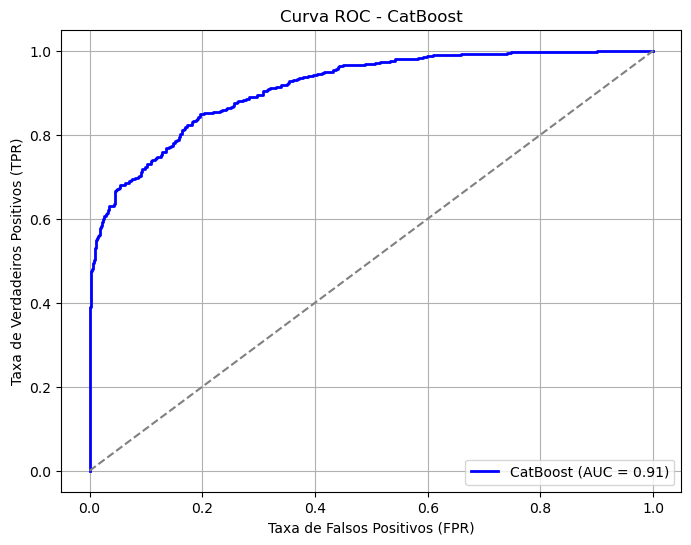

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(target_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de base
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


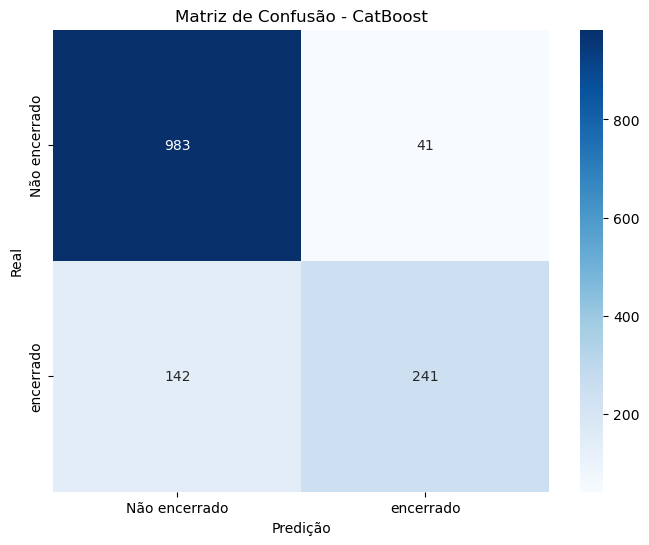

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
cm = confusion_matrix(target_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não encerrado', 'encerrado'], yticklabels=['Não encerrado', 'encerrado'])
plt.title('Matriz de Confusão - CatBoost')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()


In [79]:
# o modelo que mais de estacou foi:

print('catboost',auc_roct)

catboost 0.9160921181462143


Realizamos todo o processo passo a passo para treinar o modelo. Todos os inconvenientes encontrados foram facilmente resolvidos durante a Análise Exploratória de Dados (EDA), como a conversão de colunas, criação da coluna alvo "churn" como variável binária, e a realização de encoding e escalonamento antes de treinar os modelos testados. O projeto foi dividido em duas etapas principais: a primeira foi a EDA, onde conseguimos entender os dados e analisar as possíveis causas do problema; a segunda foi o ajuste de hiperparâmetros, onde garantimos que o modelo alcançasse uma alta pontuação AUC tanto no conjunto de teste quanto no conjunto de validação, para resolver o problema que identificamos.

o modelo com melhor desempenho foi catboost.